---
layout: post
date: 2016-01-18
title: Votes and Spending&#58;</br>
    The 2015 Philadelphia Democratic Primary City Council Race
---

{% newthought 'This analysis combines two data sources:' %} campaign finance data and election results from the city commissioner. The finance data does not contain perfect infromation. The current filing system does not appear to check for consistency in spelling across filings, nor does it require all relevant data fields to be completed. Furthermore, there is no standard for keywords for certain types of expenses. For instance, expenses listed as "donations" to Ward committees may actually be in exchange for "get out the vote" work by the committees. These and other shortcomings in the filing system limit the scope of this analysis at present considerably. However, I find a nearly logarithmic relation between expenditures in the filing cycle leading up to the election and the percentage of votes won. {% marginnote 'logistic-growth' 'Since there is an upper bound of 1 on the voter percentage, it is probably more accurate to call this logistic growth.' %}
<!--more-->

## Loading the data.
Here we download data directly from the sources.

In [1]:

import pandas as pd
import numpy as np
import urllib2

csv_dtype = {'EntityZip' : str,
             'EmployerZip': str}

data_url = 'ftp://ftp.phila-records.com/Year-to-Date%20Transaction%20Files/2015%20YTD/Explorer.Transactions.2015.YTD.txt'
data_stream = urllib2.urlopen(data_url)
#Year to date (YTD)
ytddata = pd.read_csv(data_stream,sep='\t',quotechar='"',
                      error_bad_lines=False, dtype=csv_dtype)

vote_url = 'http://www.philadelphiavotes.com/files/raw-data/2015_primary.csv'
vote_stream = urllib2.urlopen(vote_url)
primary_2015 = pd.read_csv(vote_stream,sep=',')


## Filtering data
Here we focus on cycle 3 to isolate the spending that occured up to the day of the primary. This includes most (though not all) of the get out the vote expenditures. {% sidenote 'filing-cycles' 'See filing date [information](http://www.phila.gov/records/pdfs/CFFILINGDATES.pdf).' %}

In [2]:

cycle3_data = ytddata[ytddata.Cycle==3]
print "Total number of entries in YTD campaing filings: " + str(len(ytddata))
print "Number of lines in cycle 3 filing: " + str(len(cycle3_data))

Total number of entries in YTD campaing filings: 210472
Number of lines in cycle 3 filing: 25537


I am limiting the scope of this analysis to only the Primary for Democratic seats on City Council. I am relying on a hand built table that connects the names of candidates as they appear in the city commissioners' data with how they appear in entries on campaign finance reports. {% sidenote 'Phily3-thanks' 'This table was assembled by the kind people at [Philly 3.0](https://www.philadelphia3-0.org/) after selecting a unique entry list of FilerNames from the finance data.' %} Note, candidates may have a committee filing name and a personal filing name. I combine personal and committee spending into a single entity, but this may also require removing contributions to a committee so they do not get double counted when summing expenditures.

In [4]:

tags_url = 'psi-6-2015-01-11_files/'
tags_data = pd.read_csv(tags_url+'atlcouncilfilers.csv',sep=',')
print tags_data.columns.values

['idx' 'Filers' 'Party' 'Office Sought' 'District' 'VotesName']


The 'Filers' column contains the names on the finance data. 'VotesName' column contains the candidates name as found in commissioners voting data.

In [5]:
dem_tags = tags_data[tags_data.Party=='Dem']
at_large_dem_cc_cycle3 = cycle3_data[cycle3_data.FilerName.isin(dem_tags.Filers.values)]
print "Number of lines in cycle 3 filing for\
 Democrats running for city council at large: " + str(len(at_large_dem_cc_cycle3))

Number of lines in cycle 3 filing for        Democrats running for city council at large: 2236


So only a small fraction of lines in the original finance data are for the 16 candidates running as Democrats for at large spots on City Council. There are several types of data in the `DocType` column:

In [5]:
print at_large_dem_cc_cycle3.columns.values
print '\n Document types:'
print at_large_dem_cc_cycle3.DocType.unique()

['FilerName' 'Year' 'Cycle' 'DocType' 'EntityName' 'EntityAddressLine1'
 'EntityAddressLine2' 'EntityCity' 'EntityState' 'EntityZip' 'Occupation'
 'EmployerName' 'EmployerAddressLine1' 'EmployerAddressLine2'
 'EmployerCity' 'EmployerState' 'EmployerZip' 'Date' 'Amount' 'Description'
 'Amended' 'SubDate' 'FiledBy']

 Document types:
['Campaign Finance Report (Cover Page)'
 'CFR - Schedule I - Part C - Contributions Received From Political Committees (Over $250.00)'
 'Campaign Finance Statement'
 'CFR - Schedule IV - Statement of Unpaid Depts'
 'CFR - Schedule III - Statement of Expenditures'
 'CFR - Schedule I - Part E - Other Receipts'
 'CFR - Schedule II - Part G - In-Kind Contributions Received (Value Over $250.00)'
 'CFR - Schedule II - Part F - In-Kind Contributions Received (Value of $50.01 to $250.00)'
 'CFR - Schedule I - Part B - All Other Contributions ($50.01 - $250.00)'
 'CFR - Schedule I - Part D - All Other Contributions (Over $250.00)'
 'CFR - Schedule I - Part A - Contri

Let's look at just expenditures for now. (Keep reading... this isn't the actual number.)

In [6]:
aldccc3_expenditures = at_large_dem_cc_cycle3[at_large_dem_cc_cycle3.DocType.str.contains('Expenditures')]
print 'Number of expenditures by all dem at large city council candidates during cycle 3: '\
        +str(len(aldccc3_expenditures))
print 'Total spending by those candidates: ' + str(aldccc3_expenditures.Amount.sum())

Number of expenditures by all dem at large city council candidates during cycle 3: 1081
Total spending by those candidates: 2910301.4


This is not an unbelievable number, but it seemed high to me. I took a peak inside the actual data and found many lines are duplicated when the `Amended` column is marked yes. It appears the Year-To-Date data keeps all filing submissions including those that are amended. So I wrote the following function to filter out the amended lines.

In [7]:
def filter_amends(df):
    """
    df is a ytd data frame including amended reports.
    This function filters out duplicate information in amendment stages and 
    keeps only the latest data.
    Pseudocode:
        -for each cycle check for each filer check if amended records
            -if filer in cycle had an amended record get most recent subdate:
                keep those lines
            -if filer had no amendments in cycle keep those lines
    returns a list of indices of lines in dataframe corresponding to latest
    filing data
    """
    indices_to_keep = np.array([],dtype='int64')
    cycles = df.Cycle.unique()
    for c in cycles:
        filers = df.loc[df.Cycle==c].FilerName.unique()
        dfc = df.loc[df.Cycle==c]
        for f in filers:
            dfcf = dfc.loc[dfc.FilerName==f]
            if np.sum(dfcf.Amended.str.contains('Y|y',na=False)):
                #print "amended: " + str(dfcf.SubDate.max())
                maxdate = dfcf.SubDate.max()
                #print 'amended: '+str(dfcf.loc[dfcf.SubDate == maxdate].index)
                indices_to_keep=np.append(indices_to_keep,dfcf.loc[dfcf.SubDate == maxdate].index)
            else:
                #print "not amended"
                indices_to_keep=np.append(indices_to_keep,dfcf.index)
    return indices_to_keep

In [8]:
fytddata = ytddata.iloc[filter_amends(ytddata)]
cycle3_data = fytddata[fytddata.Cycle==3]
at_large_dem_cc_cycle3 = cycle3_data[cycle3_data.FilerName.isin(dem_tags.Filers.values)]
aldccc3_expenditures = at_large_dem_cc_cycle3[at_large_dem_cc_cycle3.DocType.str.contains('Expenditures')]
print 'Number of expenditures by all dem at large city council candidates during cycle 3: '\
        +str(len(aldccc3_expenditures))
print 'Total spending by those candidates: ' + str(aldccc3_expenditures.Amount.sum())

Number of expenditures by all dem at large city council candidates during cycle 3: 909
Total spending by those candidates: 2675434.78


Not much lower, but that's the best I can discern for now. 
Let's filter the voting data now and compute the voter percentages.

In [14]:
dcc_primary_votedata = primary_2015[primary_2015.CANDIDATE.isin(dem_tags.VotesName.values)]
tot_votes = dcc_primary_votedata.VOTE.sum()
print "Total number of votes: " +str(tot_votes) #this is all votes (not all voters)
cgroup = dcc_primary_votedata.groupby('CANDIDATE').sum()
vote_pcts = (1.0*dcc_primary_votedata.groupby('CANDIDATE').sum()['VOTE'].values/tot_votes)
cgroup = cgroup.drop(['WARD','DIVISION'],axis=1)
cgroup['VOTE_PCT'] = vote_pcts
print cgroup.sort_values('VOTE_PCT')

Total number of votes: 643951
                          VOTE  VOTE_PCT
CANDIDATE                               
MARNIE AUMENT LOUGHREY   10890  0.016911
CARLA M CAIN             17115  0.026578
WILSON ALEXANDER         19210  0.029831
FRANK RIZZO              26260  0.040780
THOMAS WYATT             30310  0.047069
JENNE AYERS              32637  0.050682
PAUL STEINKE             37104  0.057619
ED NEILSON               40786  0.063337
SHERRIE COHEN            45847  0.071196
W WILSON GOODE JR        46555  0.072296
ISAIAH THOMAS            48000  0.074540
HELEN GYM                49270  0.076512
WILLIAM K GREENLEE       50849  0.078964
ALLAN DOMB               57691  0.089589
BLONDELL REYNOLDS BROWN  62922  0.097712
DEREK S GREEN            68505  0.106382


This is consistent with the voter percentages on the city commisioners website {% marginnote 'philly-votes' '[http://www.philadelphiavotes.com/](http://www.philadelphiavotes.com/)' %}.


## Analysis part 1
Let's see what's in the description of those expenditures.

In [15]:
aldccc3_expenditures.Description.value_counts()[:25]

Credit Card Processing Fee    108
Election Day Salary           101
Election Day Expenses          45
GOTV field work                44
Donation                       37
GOTV                           36
Salary                         25
Parking                        22
Consulting                     22
Election Day field             21
Contribution                   21
Advertising                    20
Printing                       19
Office Supplies                11
Election Day                   10
Gas                             7
Advertisements                  7
Mail & Media Services           7
Contribution Refund             7
Campaign Materials              6
Field Expenses                  6
Taxi                            5
Stipend                         5
Service Fee                     5
Payroll                         4
Name: Description, dtype: int64

There are a lot of questions one could ask. The `value_counts` function matches values exactly, so differences in capitalization will create new lines. And there are many other entries that probably mean identitical things, e.g., "GOTV" and "GOTV field work" and probably "Election Day Salary". It's hard to say given the current filing system.


## Add Voter data tag to campaign finances

In [16]:
def add_vote_name(x):
    x['VotesName']=dem_tags[dem_tags.Filers.str.contains(x['FilerName'].values[0])].VotesName.values[0]
    return x
aldccc3_vname = at_large_dem_cc_cycle3.groupby('FilerName').apply(add_vote_name)

In playing with the data some at this point, I noticed a couple of Council Candidates are missing data... Marnie Aument Loughrey did not file a cycle 3 report at all. This is consistent with the absence of a folder with her name in the directory at: [ftp://ftp.phila-records.com/2015/Cycle%203/](ftp://ftp.phila-records.com/2015/Cycle%203/) I also found W. Wilson Goode Jr. had no expenses in cycle 3 according to his report. They wil be excluded from the plots below.

In [17]:
dtsums = aldccc3_vname.groupby(['VotesName','DocType'])['Amount'].sum()

In [18]:
expenseslist = cgroup.copy()
for name in list(dtsums.index.levels[0].values):
    if name in dtsums[:,'CFR - Schedule III - Statement of Expenditures']:
        expenseslist.loc[name,'Expense']=dtsums[name,'CFR - Schedule III - Statement of Expenditures']

In [19]:
expenseslist

,VOTE,VOTE_PCT,Expense
CANDIDATE,,,
ALLAN DOMB,57691,0.089589,1546447.86
BLONDELL REYNOLDS BROWN,62922,0.097712,7500.20
CARLA M CAIN,17115,0.026578,280.00
DEREK S GREEN,68505,0.106382,92689.04
ED NEILSON,40786,0.063337,60258.56
FRANK RIZZO,26260,0.040780,12121.19
HELEN GYM,49270,0.076512,225899.67
ISAIAH THOMAS,48000,0.074540,107939.81
JENNE AYERS,32637,0.050682,7979.35


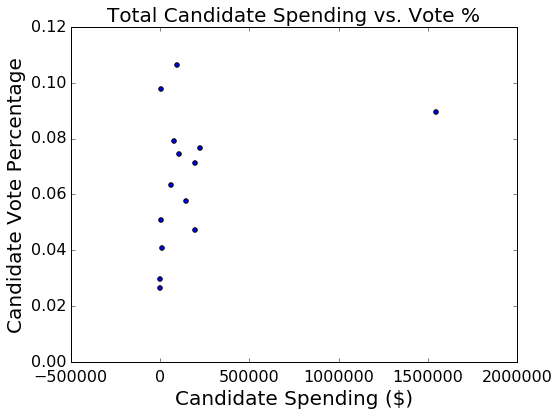

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
plt.scatter(expenseslist.Expense,expenseslist.VOTE_PCT)
plt.title('Total Candidate Spending vs. Vote %',size=20)
plt.xlabel('Candidate Spending (\$)',size=20)
plt.ylabel('Candidate Vote Percentage',size=20)
plt.tick_params(axis='x', pad=8)
plt.tick_params(axis='both', which='major', labelsize=16)

Ok, one candidate (Alan Domb) outspent the next candidate by a factor of 10.

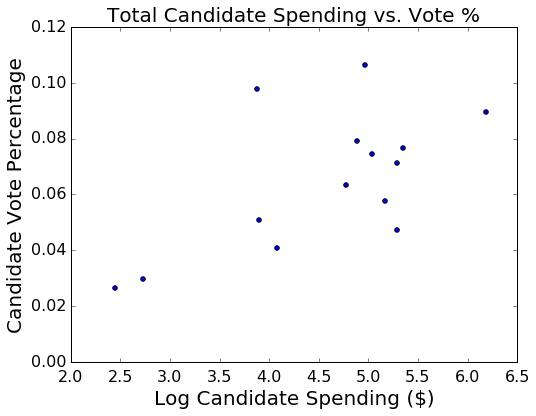

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(expenseslist.Expense),expenseslist.VOTE_PCT)
plt.title('Total Candidate Spending vs. Vote %',size=20)
plt.xlabel('Log Candidate Spending (\$)',size=20)
plt.ylabel('Candidate Vote Percentage',size=20)
plt.tick_params(axis='x', pad=8)
plt.tick_params(axis='both', which='major', labelsize=16)

Well... that's a pretty substanial return to dollars spent overall and I suspect the spending sums for some of those points is inaccurate (low).
There is much more that can be discovered in this data as Tom Ferrick has [pointed](http://mobile.philly.com/beta?wss=/philly/news/politics/mayor&id=337265201) [out](http://www.philly.com/philly/news/politics/mayor/Ferrick_Election_Day_A_big_payday_for_Philly_political_bosses.html).